In [269]:
import pandas as pd
import numpy as np

positive_sample = pd.read_csv(r'data\samples\positive_sample.csv', nrows = 20000)
negative_sample = pd.read_csv(r'data\samples\negative_sample.csv', nrows = 20000)

df = pd.concat([positive_sample,negative_sample], ignore_index= True)
df.describe()

,playtime,num_games,num_reviews
count,39943.000000,40000.000000,40000.000000
mean,151.439152,185.796275,13.783175
std,411.041404,317.324810,38.487249
min,0.020000,0.000000,1.000000
25%,7.200000,39.000000,2.000000
50%,28.100000,99.500000,5.000000
75%,117.900000,217.000000,13.000000
max,10564.120000,9972.000000,2627.000000


Some nulls in playtime. We could assume that the review was made without playing the game, but this will be checked further down.

Extreme values are present for each variable. Should be investigated.

<AxesSubplot:xlabel='playtime', ylabel='num_reviews'>

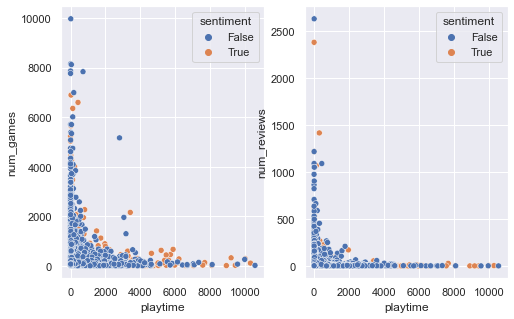

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(8,5)})

# Investigating variable populations and potential correlations by making biviriate plots. 
fig, ax = plt.subplots(1,2)
sns.scatterplot(x=df['playtime'],y=df['num_games'],hue=df['sentiment'],ax=ax[0])
sns.scatterplot(x=df['playtime'],y=df['num_reviews'],hue=df['sentiment'],ax=ax[1])

The high density at extreme values for the number of games and number of reivews imply that they could be lifetime totals. This needed checking. 

Both API documentaion and sample checking indicate that both variables are totals calculated at the API call date, not the review date. This makes them unusable for checking review sentiment.

Playtime, which was confirmed to be at the time the review was written, will be the sole variable being explored and used to predict sentiment next to the review text.

In the graphs above, playtime shows that towards higher values, measurements are much more sparse, so outlier checks need to be done.

In [271]:
# Quick investimation of null playtime values
test = pd.read_csv(r'data\unprocessed\steam_reviews.csv',nrows=300000) # Had to pull 300k rows to reach some nulls
# test.describe() # Count doesn't include nulls
test[test['author.playtime_at_review'].isna()][['review','app_id','author.steamid']].head(3)

,review,app_id,author.steamid
275823,進場cg很好看，可惜我可能對我的電腦太有信心然而它並不能承受這款遊戲,292030,76561198415819869
279970,Waiting for that pc\n\nEdit: PC Acquired,292030,76561198161620775
280047,no,292030,76561198321395122


Checking the reviews on Steam with https[]()://steamcommunity.com/profiles/**\<author.steamid\>**/recommended/**\<app_id\>**/ shows no playtime at review. For example: 
- No playtime at review:  https://steamcommunity.com/profiles/76561198199559078/recommended/292030/
- Present playtime at review: https://steamcommunity.com/profiles/76561198865592302/recommended/292030/ 

So to adjust, we'll impute 0.

### Outlier Clipping

C:\Users\Khaled\AppData\Local\Temp/ipykernel_43352/3578119716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['playtime'].isna()]['playtime']=0


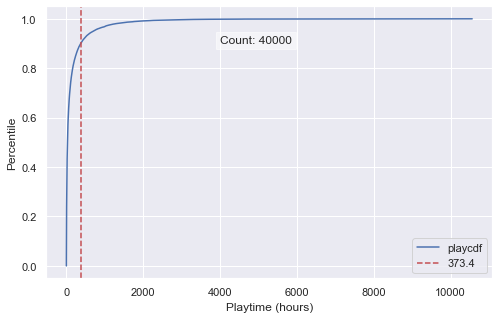

In [272]:
# Impute 0's for nulls
df.loc[df['playtime'].isna()]['playtime']=0

# Keeping only playtime and sentiment
df = df[['playtime','sentiment']]

# Calculate and plot CDF
df['playcdf']=df['playtime'].rank(method="average", pct=True)
plot = df.sort_values('playtime').plot(x='playtime', y='playcdf', xlabel ='Playtime (hours)', ylabel = 'Percentile')

# Plot the 90th percentile
perc = round(df['playtime'].quantile(0.9),1)
plt.axvline(x=perc, color='r', linestyle = '--', label=perc)

# Print the total number of values to compare with clipped set 
plt.text(4000,0.9, 'Count: '+ str(df['playtime'].size), bbox=dict(facecolor='white', alpha=0.5))
plt.legend()

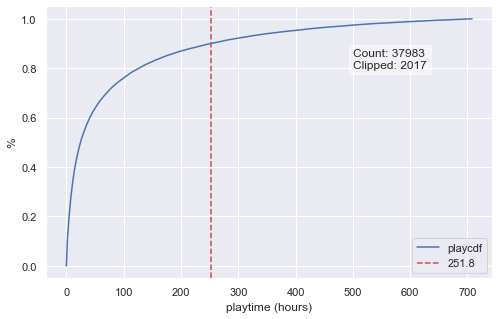

In [273]:
# Clip outliers using mean +/- 1.5 IQR with IQR between 90% and 10% 
iqr = df['playtime'].quantile(0.90) - df['playtime'].quantile(0.10)
mean = df['playtime'].mean()
upper, lower = mean + 1.5*iqr, mean - 1.5*iqr

df_iqr = pd.DataFrame
df_iqr = df[(df['playtime'] < upper) & (df['playtime'] > lower)][df.columns]

# Caclulate and plot new CDF
df_iqr['playcdf'] = df_iqr['playtime'].rank(pct=True)
plot = df_iqr.sort_values('playtime').plot(x='playtime', y='playcdf', grid=True, xlabel ='playtime (hours)', ylabel = '%')

# Plot new 90th percentile
perc = round(df_iqr['playtime'].quantile(0.9),1)
plt.axvline(x=perc, color='r', linestyle = '--', label=perc)

# Display new number of rows and how much were clipped
clip_text = 'Count: ' +str(df_iqr['playtime'].size) + '\nClipped: ' + str(df['playtime'].size - df_iqr['playtime'].size)
plt.text(500,0.8, clip_text , bbox=dict(facecolor='white', alpha=0.5))
plt.legend(loc='lower right')

<AxesSubplot:xlabel='playtime', ylabel='Percent'>

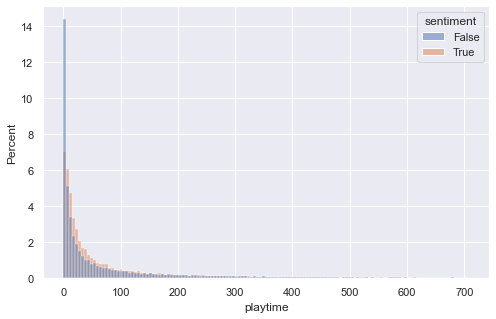

In [274]:
sns.histplot(data=df_iqr,x='playtime', hue='sentiment',stat='percent')

The data is heavily right-skewed. To get a better look, we'll apply a log transformation.

<AxesSubplot:xlabel='playtime', ylabel='Count'>

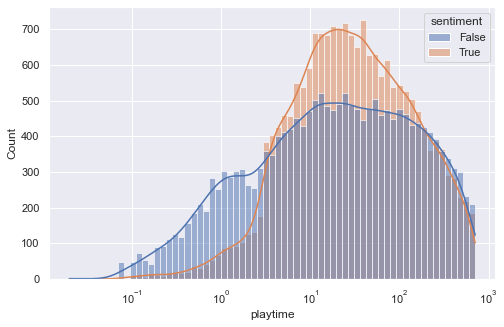

In [275]:
sns.histplot(data=df_iqr,x='playtime', hue='sentiment', log_scale=True, kde=True)

Very interesting results. Players are more likely to give a positive review the longer they play and also more likely to give a nagtive review less they play.

When games have glaring issues, bugs, or are generally not worth the money, players are likely to quit playing in the first couple of hours and post a negative review. On the other hand, when players enjoy a game, or at least don't see significant issues, they're more likely to keep playing and/or complete the game before leaving a review. In that sense, games that generally keep players playing for longer periods are more likely to receive positive reviews, but the chance of still receiving negative reviews after longer playtimes is still significant.

Overall, this data shows some promise in using playtime as a predictor for sentiment, but with the signifcant overlap between both distributions, it's more likely to be a weaker predictor.

In [339]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df_iqr[['playtime']].to_numpy(),df_iqr[['sentiment']].to_numpy().ravel())

X_train = np.log(X_train)
X_test = np.log(X_test)

clf = LogisticRegression(max_iter=400).fit(X_train,y_train)
y_pred = clf.predict(X_test)

print(accuracy_score(y_test,y_pred))

0.5457034540859309


As expected, even when log transformed, the overlap of the distributions and nuance of the observed differences make it a weak predictor. Using a simple logistic regression doesn't allow our model to utilize the differences as much as it could, so a more complex model, a neural network, can be tested.

In [342]:
from sklearn.neural_network import MLPClassifier

clf_nn = MLPClassifier(hidden_layer_sizes=(50)).fit(X_train,y_train)
y_pred_nn = clf_nn.predict(X_test)

print(accuracy_score(y_test,y_pred_nn))

0.5923546756529064


A shallow neural network with one hidden layer gives better accuracy, but overall, playtime is still a relatively weak predictor compared to the the review text. Next, we'll fit a model with both playtime and the text features and look for changes in the model's accuracy compared to using just the review text.